# SVR

## Load Packages

In [108]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF, PCA
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import shap
import matplotlib.pyplot as plt

## Load Dataset

In [109]:
# Load fps feature data
X_fps_train = pd.read_csv('./data/X_fps_train.csv', index_col=0)
X_fps_public_test = pd.read_csv('./data/X_fps_public_test.csv', index_col=0)
X_fps_private_test = pd.read_csv('./data/X_fps_private_test.csv', index_col=0)

# Load embed feature data
X_embed_train = pd.read_csv('./data/X_embed_train.csv', index_col=0)
X_embed_public_test = pd.read_csv('./data/X_embed_public_test.csv', index_col=0)
X_embed_private_test = pd.read_csv('./data/X_embed_private_test.csv', index_col=0)

# Load response data
y_train = pd.read_csv('./data/y_train.csv', index_col=0).to_numpy() # outputs of the training set
y_public_test = pd.read_csv('./data/y_public_test.csv', index_col=0).to_numpy() # outputs of the training set

# set index of random shuffle
np.random.seed(2025)
random_idx = np.random.permutation(y_train.shape[0])
# shuffle the training dataset
X_fps_train = X_fps_train.iloc[random_idx].reset_index(drop=True)
X_embed_train = X_embed_train.iloc[random_idx].reset_index(drop=True)
y_train = y_train[random_idx]

[CV 4/5] END C=1, degree=2, epsilon=0.01, gamma=scale, kernel=poly;, score=-0.479 total time=   0.7s
[CV 5/5] END C=1, degree=2, epsilon=0.01, gamma=auto, kernel=rbf;, score=-1.026 total time=   0.8s
[CV 5/5] END C=1, degree=2, epsilon=0.01, gamma=0.1, kernel=poly;, score=-0.522 total time=   0.7s
[CV 5/5] END C=1, degree=2, epsilon=0.01, gamma=1, kernel=poly;, score=-0.528 total time=   0.7s
[CV 4/5] END C=1, degree=2, epsilon=0.1, gamma=scale, kernel=poly;, score=-0.484 total time=   0.6s
[CV 4/5] END C=1, degree=2, epsilon=0.1, gamma=auto, kernel=poly;, score=-1.321 total time=   0.6s
[CV 3/5] END C=1, degree=2, epsilon=0.1, gamma=0.1, kernel=poly;, score=-0.560 total time=   0.6s
[CV 4/5] END C=1, degree=2, epsilon=0.1, gamma=1, kernel=rbf;, score=-1.349 total time=   0.7s
[CV 1/5] END C=1, degree=3, epsilon=0.01, gamma=scale, kernel=poly;, score=-0.486 total time=   0.7s
[CV 3/5] END C=1, degree=3, epsilon=0.01, gamma=auto, kernel=rbf;, score=-1.100 total time=   0.8s
[CV 4/5] END

## First Phrase: Dimensionality Reduction Search with fix parameter

In [110]:
dim_reduct_ls = ["none", "PCA", "NMF", "random_projection"]

In [111]:
fixed_svr_params = {'C': 1.0, 'epsilon': 0.1, 'gamma': 1, 'kernel': 'rbf'}
fixed_elastic_params = {'alpha': 0.1, 'l1_ratio': 0.5}

In [112]:
# Define dimensionality reduction methods for each feature type
def get_dim_reduction(method, feature_type, n_components=50):
    if method == "PCA":
        return PCA(n_components=n_components)
    elif method == "NMF":
        return NMF(n_components=n_components, init='nndsvd', random_state=42, tol=0.03)
    elif method == "random_projection":
        if feature_type == "fps":
            return SparseRandomProjection(n_components=n_components, random_state=42)
        elif feature_type == "embed":
            return GaussianRandomProjection(n_components=n_components, random_state=42)
    return None  # "none" means no dimensionality reduction

In [113]:
def evaluate_dim_reduction(model, X_train, y_train, feature_type):

    dim_reduct_ls = ["none", "PCA", "NMF"] #, "random_projection"]
    results = []

    for method in dim_reduct_ls:
        dim_reduction = get_dim_reduction(method, feature_type)

        if dim_reduction:
            pipeline = Pipeline([
                ('dim_reduction', dim_reduction),
                ('regressor', model)
            ])
        else:
            pipeline = Pipeline([
                ('regressor', model)
            ])

        # Cross-validation scores
        mse_scores = cross_val_score(pipeline, X_train, y_train.ravel(), cv=5, scoring='neg_mean_squared_error', error_score='raise')
        mae_scores = cross_val_score(pipeline, X_train, y_train.ravel(), cv=5, scoring='neg_mean_absolute_error')
        r2_scores = cross_val_score(pipeline, X_train, y_train.ravel(), cv=5, scoring='r2')

        mse = -np.mean(mse_scores)  # Convert from negative MSE
        mae = -np.mean(mae_scores)  # Convert from negative MAE
        r2 = np.mean(r2_scores)

        print(f"Feature: {feature_type}, Method: {method}, MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

        results.append({
            "Feature": feature_type,
            "Method": method,
            "MSE": mse,
            "MAE": mae,
            "R²": r2
        })

    # Convert results to a DataFrame for better visualization
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="MSE")  # Sort by MSE (lower is better)
    
    return results_df

In [114]:
models = {
    "SVR": SVR(C=1.0, epsilon=0.1, gamma="scale", kernel='rbf'),
}

scaler_embed = MinMaxScaler(feature_range=(0, 1))  # Forces range between 0 and 1
X_embed_train = scaler_embed.fit_transform(X_embed_train)
X_embed_public_test = scaler_embed.transform(X_embed_public_test)

X_train_dict = {
    "fps": X_fps_train,
    "embed": X_embed_train
}

# Evaluate for both feature types: fps & embed
for model_name, model in models.items():
    for feature_type in ["fps", "embed"]:
        print(f"\nModel: {model_name}")
        print(f"Evaluating dimensionality reduction for feature type: {feature_type}")
        
        results_df = evaluate_dim_reduction(model, X_train_dict[feature_type], y_train, feature_type)


Model: SVR
Evaluating dimensionality reduction for feature type: fps
[CV 4/5] END C=1, degree=2, epsilon=0.01, gamma=scale, kernel=rbf;, score=-0.493 total time=   0.8s
[CV 1/5] END C=1, degree=2, epsilon=0.01, gamma=auto, kernel=poly;, score=-1.409 total time=   0.7s
[CV 4/5] END C=1, degree=2, epsilon=0.01, gamma=0.1, kernel=rbf;, score=-0.753 total time=   0.8s
[CV 5/5] END C=1, degree=2, epsilon=0.01, gamma=1, kernel=rbf;, score=-1.371 total time=   0.8s
[CV 2/5] END C=1, degree=2, epsilon=0.1, gamma=scale, kernel=poly;, score=-0.484 total time=   0.6s
[CV 3/5] END C=1, degree=2, epsilon=0.1, gamma=auto, kernel=rbf;, score=-1.101 total time=   0.7s
[CV 4/5] END C=1, degree=2, epsilon=0.1, gamma=0.1, kernel=poly;, score=-0.453 total time=   0.6s
[CV 3/5] END C=1, degree=2, epsilon=0.1, gamma=1, kernel=poly;, score=-0.562 total time=   0.6s
[CV 3/5] END C=1, degree=3, epsilon=0.01, gamma=scale, kernel=rbf;, score=-0.695 total time=   0.7s
[CV 2/5] END C=1, degree=3, epsilon=0.01, ga

In [115]:
X_embed_public_test = np.clip(X_embed_public_test, 0, 1)
# Check if embed contains negative values **before applying NMF**
print("Min value in X_embed_train:", np.min(X_embed_train))
print("Min value in X_embed_test:", np.min(X_embed_public_test))

# Train-Test dictionaries
X_train_dict = {
    "fps": X_fps_train,
    "embed": X_embed_train
}
X_test_dict = {
    "fps": X_fps_public_test,
    "embed": X_embed_public_test
}

# Store results
test_results = []

# Train and evaluate models with each dimensionality reduction method
for model_name, model in models.items():
    for feature_type in ["fps", "embed"]:
        for dim_name in dim_reduct_ls:
            
            # Apply dimensionality reduction
            dim_reduction = get_dim_reduction(dim_name, feature_type, n_components=50)
            if dim_reduction:
                X_train_reduced = dim_reduction.fit_transform(X_train_dict[feature_type])
                X_test_reduced = dim_reduction.transform(X_test_dict[feature_type])
            else:
                X_train_reduced = X_train_dict[feature_type]
                X_test_reduced = X_test_dict[feature_type]

            # Train the model
            model.fit(X_train_reduced, y_train.ravel())

            # Predict on test set
            y_pred = model.predict(X_test_reduced)

            # Compute Test MSE
            mse_test = mean_squared_error(y_public_test, y_pred)
            # mae_test = mean_absolute_error(y_test, y_pred)

            print(f"MSE for {model_name} on {feature_type} using {dim_name}: {mse_test:.4f}")
            # print(f"MAE for {model_name} on {feature_type} using {dim_name}: {mae_test:.4f}")

            test_results.append([model_name, feature_type, dim_name, mse_test])

# Convert results to DataFrame
test_results_df = pd.DataFrame(test_results, columns=["Model", "Feature", "Dim Reduction", "Test MSE"])


Min value in X_embed_train: 0.0
Min value in X_embed_test: 0.0
MSE for SVR on fps using none: 0.8240
MSE for SVR on fps using PCA: 0.9574
MSE for SVR on fps using NMF: 1.5002
MSE for SVR on fps using random_projection: 0.9281
MSE for SVR on embed using none: 0.8202
MSE for SVR on embed using PCA: 0.6817
MSE for SVR on embed using NMF: 0.7788
MSE for SVR on embed using random_projection: 1.0585


## Second Phrase: Hyperparameter Optimization
- C (Regularization parameter): Controls the trade-off between achieving a low error and avoiding overfitting.
- epsilon (Epsilon-tube for loss function): Specifies how much deviation from the actual value is ignored.
- gamma (Kernel coefficient for ‘rbf’ and ‘poly’ kernels): Controls the influence of individual data points.
- kernel (Type of kernel function): Options = ['linear', 'rbf', 'poly'].

### fps

In [116]:
# Define refined hyperparameter grids for **fine-tuning**
param_grid_svr = {
    'regressor__C': [1, 10, 100], 
    'regressor__epsilon': [0.01, 0.01, 0.1, 1],
    'regressor__kernel': ['rbf', 'poly'],
    'regressor__gamma': ['scale','auto', 0.1, 1],
    'regressor__degree': [3, 4]
}

In [117]:
# Define SVR model
svr = SVR()

# Create pipeline (if using feature transformations)
pipeline = Pipeline([
    ('regressor', svr)  # Add other preprocessing steps if needed
])

# Run GridSearchCV for SVR
grid_search = GridSearchCV(
    pipeline, param_grid_svr, 
    cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose = 5
)
grid_search.fit(X_fps_train, y_train.ravel())

best_svr_fps_model = grid_search.best_estimator_
best_svr_fps_params = grid_search.best_params_
best_fps_validation_mse = -grid_search.best_score_

print()
print("Best Parameters:", best_svr_fps_params)
print(f"Best Validation MSE: {best_fps_validation_mse:.5f}")

Fitting 5 folds for each of 192 candidates, totalling 960 fits

Best Parameters: {'regressor__C': 10, 'regressor__degree': 3, 'regressor__epsilon': 0.01, 'regressor__gamma': 'scale', 'regressor__kernel': 'rbf'}
Best Validation MSE: 0.47572


In [118]:
best_svr_fps_model.fit(X_fps_train, y_train.ravel())

y_pred = best_svr_fps_model.predict(X_fps_public_test)
# Compute Test Errors
mse_fps_test = mean_squared_error(y_public_test, y_pred)
mae_fps_test = mean_absolute_error(y_public_test, y_pred)

# Print results
print(f"Test Error - MSE: {mse_fps_test:.4f}, MAE: {mae_fps_test:.4f}")

Test Error - MSE: 0.7204, MAE: 0.6781


#### Refit the best fps model and draw SHAP plot

In [119]:
best_svr_fps_model = SVR(C=10, epsilon=0.01, gamma = "scale", kernel='rbf', degree=3) 
best_svr_fps_model.fit(X_fps_train, y_train.ravel())

SVR(C=10, epsilon=0.01)

In [120]:
X_test_fps_background = shap.sample(X_fps_train, 400)
# use KernelExplainer for SHAP analysis
explainer = shap.KernelExplainer(best_svr_fps_model.predict, X_test_fps_background)

Using 400 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [121]:
# shap_values = explainer.shap_values(X=X_fps_public_test, nsamples=400)
# 
# import pickle as pkl
# with open("./svr_shap_values/SVR_fps_shap_values.pkl", "wb") as file:
#     pkl.dump(shap_values, file)

In [122]:
import pickle as pkl
with open("./svr_shap_values/SVR_fps_shap_values.pkl", "rb") as file:
    shap_values = pkl.load(file)

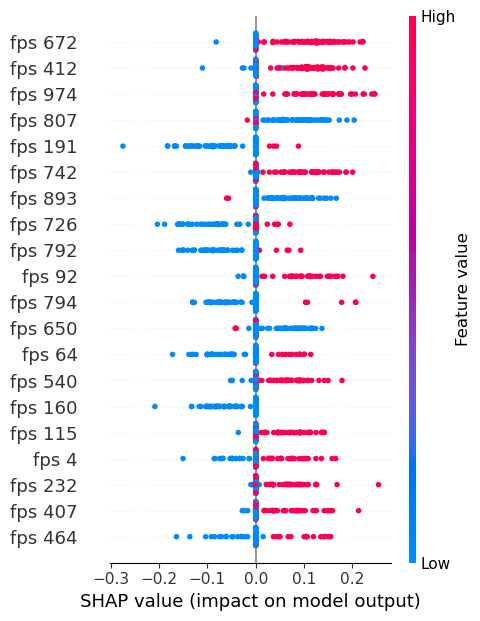

In [123]:
shap.initjs()
shap.summary_plot(shap_values, X_fps_public_test, max_display = 20, show=False)
# Iterate through y axis labels to set new feature names to fps/embed index form
ax = plt.gca()
new_labels = []
for text in ax.get_yticklabels():
    feature_name = text.get_text()
    feature_idx = int(feature_name.split(" ")[-1])
    
    new_label = f"fps {feature_idx}"
    
    new_labels.append(new_label)
    
ax.set_yticklabels(new_labels)

fig = plt.gcf()
fig.set_size_inches(4, 6)

plt.savefig(f"./svr_fps_SHAP.png", dpi=300, bbox_inches='tight')
plt.show()

### embed

In [124]:
# Apply MinMaxScaler only to `embed`
scaler_embed = MinMaxScaler(feature_range=(0, 1))
X_embed_train = scaler_embed.fit_transform(X_embed_train)
X_embed_public_test = scaler_embed.transform(X_embed_public_test)

In [125]:
param_grid_embed = {
    'pca__n_components': [120, 130, 140],
    'regressor__C': [1, 10, 100],
    'regressor__epsilon': [0.01, 0.1, 1],
    'regressor__kernel': ['rbf', 'poly'],
    'regressor__gamma': ['scale','auto', 0.1, 1],
    'regressor__degree': [3, 4]
}

In [126]:
# Create pipeline (if using feature transformations)
pipeline = Pipeline([
    ('pca', PCA()),
    ('regressor', SVR()) 
])

# Run GridSearchCV for SVR
grid_search = GridSearchCV(
    pipeline, param_grid_embed, 
    cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose = 5
)
grid_search.fit(X_embed_train, y_train.ravel())

best_svr_embed_model = grid_search.best_estimator_
best_svr_embed_params = grid_search.best_params_
best_validation_mse = -grid_search.best_score_

print("Best Parameters:", best_svr_embed_params)
print(f"Best Validation MSE: {best_validation_mse:.5f}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'pca__n_components': 130, 'regressor__C': 10, 'regressor__degree': 3, 'regressor__epsilon': 0.1, 'regressor__gamma': 'scale', 'regressor__kernel': 'rbf'}
Best Validation MSE: 0.68193


In [128]:
best_svr_embed_model.fit(X_embed_train, y_train.ravel())

y_pred = best_svr_embed_model.predict(X_embed_public_test)
# Compute Test Errors
mse_test = mean_squared_error(y_public_test, y_pred)
mae_test = mean_absolute_error(y_public_test, y_pred)

# Print results
print(f"Test Error - MSE: {mse_test:.4f}, MAE: {mae_test:.4f}")

Test Error - MSE: 0.6759, MAE: 0.6575


#### Refit the best embed model and draw SHAP plot

In [129]:
# Step 1: Apply PCA to embed features
pca = PCA(n_components=130)  # You can choose n_components based on tuning
X_embed_train_pca = pca.fit_transform(X_embed_train)
X_embed_public_test_pca = pca.transform(X_embed_public_test)

best_svr_embed = SVR(C=10, epsilon=0.1, gamma="scale", kernel='rbf', degree=3)
best_svr_embed.fit(X_embed_train_pca, y_train.ravel())

SVR(C=10)

In [130]:
X_test_embed_background = shap.sample(X_embed_train_pca, 100)
# use KernelExplainer for SHAP analysis
explainer = shap.KernelExplainer(best_svr_embed.predict, X_test_embed_background)

In [131]:
# shap_values = explainer.shap_values(X=X_embed_public_test_pca, nsamples=400)
# import pickle as pkl
# with open("./svr_shap_values/SVR_embed_shap_values.pkl", "wb") as file:
#     pkl.dump(shap_values, file)

In [132]:
import pickle as pkl
with open("./svr_shap_values/SVR_embed_shap_values.pkl", "rb") as file:
    shap_values = pkl.load(file)

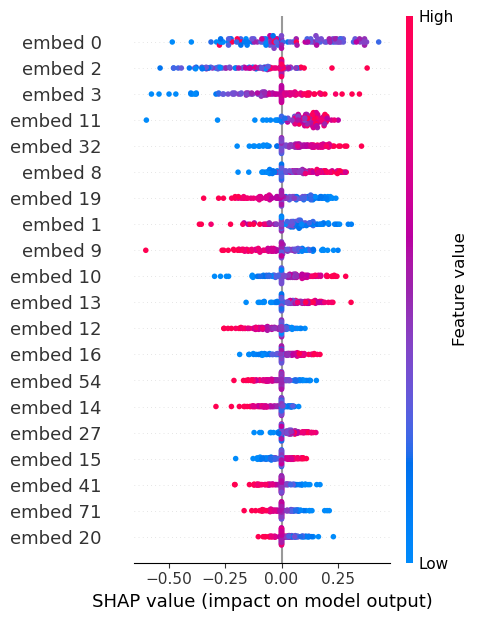

In [133]:
shap.initjs()
shap.summary_plot(shap_values, X_embed_public_test_pca, max_display = 20, show=False)
# Iterate through y axis labels to set new feature names to fps/embed index form
ax = plt.gca()
new_labels = []
for text in ax.get_yticklabels():
    feature_name = text.get_text()
    feature_idx = int(feature_name.split(" ")[-1])
    
    new_label = f"embed {feature_idx}"

    new_labels.append(new_label)

ax.set_yticklabels(new_labels)

fig = plt.gcf()
fig.set_size_inches(4, 6)

plt.savefig(f"./svr_embed_SHAP.png", dpi=300, bbox_inches='tight')
plt.show()

### Joint Dataset

In [134]:
# Step 1: Concatenate fps and embed features
X_train_joint = pd.DataFrame(np.hstack((X_fps_train, X_embed_train)))
X_test_joint = pd.DataFrame(np.hstack((X_fps_public_test, X_embed_public_test)))

# Step 2: Ensure y_train is in 1D format
y_train = y_train.flatten()
y_public_test = y_public_test.flatten()

In [135]:
param_grid_svr = {
    'C': [1, 10, 100],  # Regularization parameter
    'epsilon': [0.01, 0.1],  # Tolerance margin
    'kernel': ['rbf', 'poly'],  # Kernel types
    'degree': [2, 3, 4], # Only used for polynomial kernel
    'gamma': ['scale','auto', 0.1, 1]
}

In [136]:
grid_search = GridSearchCV(
    svr, param_grid_svr, 
    cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose = 5
)
grid_search.fit(X_train_joint, y_train)

best_svr_model = grid_search.best_estimator_
best_svr_params = grid_search.best_params_
best_validation_mse = -grid_search.best_score_

print("Best Parameters:", best_svr_params)
print(f"Best Validation MSE: {best_validation_mse:.4f}")

y_pred = best_svr_model.predict(X_test_joint)

mse_test = mean_squared_error(y_public_test, y_pred)
mae_test = mean_absolute_error(y_public_test, y_pred)

print(f"Test Error - MSE: {mse_test:.4f}, MAE: {mae_test:.4f}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Validation MSE: 0.4528
Test Error - MSE: 0.6299, MAE: 0.6394


#### Refit the best joint model and draw SHAP plot

In [137]:
best_svr_joint = SVR(C=10, epsilon=0.1, kernel='rbf', degree=2, gamma="scale")  # Best params from previous tuning

best_svr_joint.fit(X_train_joint, y_train)

SVR(C=10, degree=2)

In [138]:
X_test_joint_background = shap.sample(X_train_joint, 100)
# use KernelExplainer for SHAP analysis
explainer = shap.KernelExplainer(best_svr_joint.predict, X_test_joint_background)

In [139]:
# shap_values = explainer.shap_values(X=X_test_joint, nsamples=500)
# import pickle as pkl
# with open("./svr_shap_values/SVR_joint_shap_values.pkl", "wb") as file:
#     pkl.dump(shap_values, file)

In [140]:
import pickle as pkl
with open("./svr_shap_values/SVR_joint_shap_values.pkl", "rb") as file:
    shap_values = pkl.load(file)

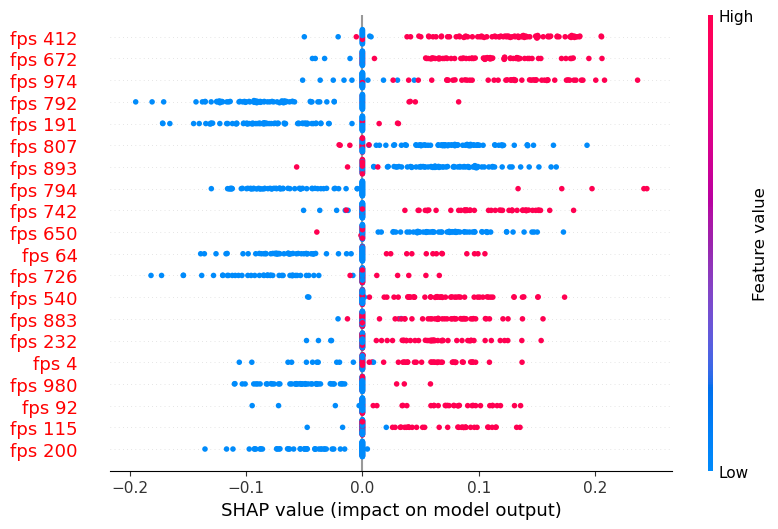

In [141]:
shap.initjs()
shap.summary_plot(shap_values, X_test_joint, max_display = 20, show=False)
# Iterate through y axis labels to set new feature names to fps/embed index form
ax = plt.gca()
new_labels = []
for text in ax.get_yticklabels():
    feature_name = text.get_text()
    feature_idx = int(feature_name.split(" ")[-1])
    
    # Rename feature
    if feature_idx < 1024:
        new_label = f"fps {feature_idx}"
        text.set_color('red')  # Highlight in red
    else:
        new_label = f"embed {feature_idx - 1024}"
    new_labels.append(new_label)
    
ax.set_yticklabels(new_labels)

fig = plt.gcf()
fig.set_size_inches(8, 5)

plt.savefig(f"./svr_joint_SHAP.png", dpi=300, bbox_inches='tight')
plt.show()